# SETUP


## Imports

In [1]:
from __future__ import annotations
from scipy.optimize import minimize, root_scalar
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
import gc


## Classes

In [2]:
class Fluid:
    """
    Stores the constant properties R and gamma of a fluid
    """

    def __init__(self, R: float, gamma: float) -> None:
        self.R = R
        self.gamma = gamma

    def __str__(self) -> str:
        return f"Fluid(R={self.R}, gamma={self.gamma})"


Flow class uses a few equations from @anderson2017, repeated here as they appear in the book:


From chapter 8:

$$\tag{8.25}
  a = \sqrt{\gamma R T}
$$

$$\tag{8.40}
  \frac{T_0}{T} = 1 + \frac{\gamma - 1}{2}M^2
$$

$$\tag{8.42}
  \frac{p_0}{p} = \left( 1 + \frac{\gamma - 1}{2}M^2 \right) ^ {\frac{\gamma}{\gamma - 1}}
$$

$$\tag{8.43}
  \frac{\rho_0}{\rho} = \left( 1 + \frac{\gamma - 1}{2}M^2 \right) ^ {\frac{1}{\gamma - 1}}
$$


From chapter 9
$$\tag{9.13}
  M_{n,1} = M_1 \sin\beta
$$

$$\tag{9.14}
  {M_{n,2}}^2 = \frac{
    1 + \frac{\gamma - 1}{2} {M_{n,1}}^2
  }{
    \gamma {M_{n,1}}^2 - \frac{\gamma - 1}{2}
  }
$$

$$\tag{9.15}
  \frac{\rho_2}{\rho_1} = \frac{ (\gamma + 1) {M_{n,1}}^2 }{ 2 + (\gamma + 1) {M_{n,1}}^2 }
$$

$$\tag{9.16}
  \frac{p_2}{p_1} = 1 + \frac{2}{\gamma + 1} ( {M_{n,1}}^2 - 1 )
$$

$$\tag{9.17}
  \frac{T_2}{T_1} = \frac{p_2}{p_1} \frac{\rho_1}{\rho_2}
$$

$$\tag{9.18}
  M_2 = \frac{M_{n,2}}{\sin(\beta - \theta)}
$$

$$\tag{9.23}
  \tan\theta = 2 \cot\beta \frac{ {M_1}^2\sin^2\beta - 1 }{ {M_1}^2 (\gamma + \cos(2\beta)) + 2 }
$$

In [3]:
class Flow:
    """
    Stores the defining properties of a flow:
    
    Pressure (p)
    Mach Number (M)
    Temperature (T)
    Density (rho)
    Fluid (fluid)
    Speed of sound (a)
    Velocity (V)

    Care should be taken to use consistent units.
    """

    def __init__(self, p: float, M: float, T: float, rho: float, fluid: Fluid) -> None:
        """
        Constructs a Flow object from the defining properties and calculates some
        auxiliary properties.
        Uses Equations (8.25), (8.40), (8.42), (8.43) @anderson2017.

        Parameters:
        p: pressure [Pa]
        M: Mach number
        T: temperature [K]
        rho: density [kg/m^3]
        fluid: Fluid object
        """

        self.pressure = p
        self.mach = M
        self.temperature = T
        self.density = rho
        self.fluid = fluid

        # Equation (8.25) @anderson2017
        self.snd_spd = np.sqrt(fluid.gamma * fluid.R * self.temperature)
        # From the definition of Mach Number
        self.vel = M * self.snd_spd

        aux_const = 1 + (fluid.gamma - 1) * M * M / 2
        # Equation (8.40) @anderson2017
        self.total_temperature = T * aux_const
        # Equation (8.42) @anderson2017
        self.total_pressure = p * aux_const ** (fluid.gamma / (fluid.gamma - 1))
        # Equation (8.43) @anderson2017
        self.total_density = rho * aux_const ** (1 / (fluid.gamma - 1))

        self.shockwave = lru_cache(maxsize=8)(self._shockwave)

    @classmethod
    def from_total_values(
        cls, p0: float, M: float, T0: float, rho0: float, fluid: Fluid
    ):
        f = 1 / Flow(1 / p0, M, 1 / T0, 1 / rho0, fluid).total_values()
        return Flow(f[0], M, f[1], f[2], fluid)

    def _p_ratio(M, gamma):
        """
        Calculates the pressure ratio of a shockwave.
        Uses equation (9.19) @anderson2017.

        Parameters:
        M: Mach number
        gamma: ratio of specific heats

        Returns:
        Pressure ratio
        """

        return (1 + (gamma - 1) * M * M / 2) ** (gamma / (gamma - 1))

    def __str__(self) -> str:
        return (
            "\n\t".join(
                [
                    "Flow(",
                    f"Pressure: {self.pressure:.4}",
                    f"Mach: {self.mach:.4}",
                    f"Temperature: {self.temperature:.4}",
                    f"Density: {self.density:.4}",
                    f"fluid: {self.fluid}",
                ]
            )
            + "\n)"
        )

    def static_values(self) -> np.ndarray:
        """
        Outputs the defining properties of a flow as an ndarray.
        Uses same order as __init__, but excludes the fluid property.
        [p, M, T, rho]
        """
        return np.array([self.pressure, self.mach, self.temperature, self.density])

    def total_values(self) -> np.ndarray:
        """
        Outputs the stagnation properties of a flow as an ndarray.
        [p0, T0, rho0]
        """
        return np.array(
            [self.total_pressure, self.total_temperature, self.total_density]
        )

    def aux_values(self) -> np.ndarray:
        """
        Outputs the auxiliary properties of a flow as an ndarray.
        [a, V]
        """
        return np.array([self.snd_spd, self.vel])

    def _shockwave(self, beta) -> Flow:
        """
        Calculates flow properties after an oblique shockwave.
        Uses equations (9.13) through (9.18) @anderson2017.

        Parameters:
        beta: oblique angle of the shockwave [rad]

        Returns:
        The Flow object after the shockwave
        """

        # Checks shockwave is valid (supersonic and positive theta)
        # Maybe subsonic flow could be accepted, and spit a supersonic flow?
        if (self.mach < 1) or ((theta := self.velocity_deflection(beta)) <= 0):
            return Flow(np.nan, np.nan, np.nan, np.nan, self.fluid)

        gamma = self.fluid.gamma

        # Equation (9.13) @anderson2017
        M_n_1 = self.mach * np.sin(beta)
        M_n_1_sq = M_n_1 * M_n_1
        # Equation (9.14) @anderson2017 (modified)
        M_n_2 = np.sqrt(
            (2 + (gamma - 1) * M_n_1_sq) / (2 * gamma * M_n_1_sq - (gamma - 1))
        )
        # Equation (9.15) @anderson2017
        rho_2 = self.density * (gamma + 1) * M_n_1_sq / (2 + (gamma - 1) * M_n_1_sq)
        # Equation (9.16) @anderson2017
        p_2 = self.pressure * (1 + 2 * gamma * (M_n_1_sq - 1) / (gamma + 1))
        # Equation (9.17) @anderson2017
        T_2 = self.temperature * p_2 * self.density / (self.pressure * rho_2)
        # Equation (9.18) @anderson2017
        M_2 = M_n_2 / np.sin(beta - theta)

        flow_2 = Flow(p_2, M_2, T_2, rho_2, self.fluid)
        return flow_2

    def velocity_deflection(self, beta: float) -> float:
        """
        Calculates the velocity deflection angle theta for an oblique shockwave
        Uses equations (9.13), (9.23) @anderson2017
        
        Parameters:
        beta: oblique angle of the shockwave [rad]

        Returns:
        angle of deflection of velocity [rad]
        """

        M = self.mach
        gamma = self.fluid.gamma

        # Equation (9.13) @anderson2017
        M_n_1 = M * np.sin(beta)

        # Equation (9.23) @anderson2017
        theta = np.arctan(
            2
            / np.tan(beta)
            * (M_n_1 * M_n_1 - 1)
            / (M * M * (gamma + np.cos(2 * beta)) + 2)
        )
        return theta


## Functions

Area-Mach number relation @anderson2017:
$$\tag{10.32}
\left( \frac{A}{A^*} \right)^2 = \frac{1}{M^2} \left[ \frac{2}{\gamma + 1} \left( 1 + \frac{\gamma - 1}{2} M^2 \right) \right]^{\frac{\gamma+1}{\gamma-1}}
$$

In [4]:
def area_mach(M: float, gamma: float) -> float:
    """
    Calculates the ratio A / A* in isentropic quasi-one-dimensional flow.
    Uses Equation (10.32) @anderson2017.

    Parameters:
    M: Mach number
    gamma: Specific heat ratio
    """
    g_ratio = (gamma + 1) / (gamma - 1)
    # Equation (10.32) @anderson2017 (modified)
    return (2 / (gamma + 1) + M * M / g_ratio) ** (g_ratio / 2) / M


In [5]:
def nShock_p0_eff(betas: tuple[float, ...], flow_in: Flow) -> float:
    """
    Calculates the total pressure efficiency in a diffuser with n-1 oblique and 1 normal
    shockwaves.

    Parameters:
    betas: angles of the n-1 oblique shockwaves [rad]
    flow_in: Flow object of the flown in the upstream

    Returns:
    Total pressure efficiency of the diffuser
    """

    flow_after = flow_in
    for beta in betas:
        flow_after = flow_after.shockwave(beta)
    flow_after = flow_after.shockwave(np.pi / 2)
    return flow_after.total_pressure / flow_in.total_pressure


In [6]:
def bellNozzleGenerator(R_in, R_throat, R_out, L_throat, L_in=1, L_out=None):
    """
    Generates a function describing the geometry of a planar nozzle defined by 3 arcs.
    
    Parameters:
    R_in: Radius of the inlet arc
    R_throat: Radius of the throat arc
    R_out: Radius of the outlet arc
    L_throat: semi-length of the throat
    L_in: semi-length of the inlet arc
    L_out: semi-length of the outlet arc

    Returns:
    bellCurve: The function describing the geometry of the nozzle
    crit_len: The length where minimum area occurs
    max_len: The length of the nozzle
    """
    if L_out is None:
        L_out = L_in
    L1 = (
        np.sqrt((R_in + R_throat) ** 2 - (R_in - L_in + R_throat + L_throat) ** 2)
        * R_in
        / (R_in + R_throat)
    )
    l1 = L1 * R_throat / R_in
    L2 = (
        np.sqrt((R_throat + R_out) ** 2 - (R_out - L_out + R_throat + L_throat) ** 2)
        * R_out
        / (R_throat + R_out)
    )
    l2 = L2 * R_throat / R_out
    max_len = L1 + l1 + l2 + L2
    crit_len = L1 + l1

    def bellCurve(x):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        y = np.zeros_like(x)
        # First arc
        i1 = (0 <= x) & (x <= L1)
        y[i1] = L_in - R_in + np.sqrt(R_in ** 2 - (x[i1] - 0) ** 2)
        # Second arc
        i2 = (L1 < x) & (x < max_len - L2)
        y[i2] = L_throat + R_throat - np.sqrt(R_throat ** 2 - (x[i2] - (L1 + l1)) ** 2)
        # Third arc
        i3 = (max_len - L2 <= x) & (x <= max_len)
        y[i3] = L_out - R_out + np.sqrt(R_out ** 2 - (x[i3] - max_len) ** 2)
        return y

    return bellCurve, crit_len, max_len


In [7]:
def coneNozzleGenerator(crit_len, max_len, L_throat, L_in=1, L_out=None):
    """
    Generates a function describing the geometry of a planar nozzle defined by 2 slopes.

    Parameters:
    max_len: Length of the nozzle
    crit_len: Length where minimum area occurs
    L_throat: Semi-length of the throat
    L_in: Semi-length of the inlet
    L_out: Semi-length of the outlet

    Returns:
    coneCurve: The function describing the geometry of the nozzle
    crit_len: The length where minimum area occurs
    max_len: The length of the nozzle
    """
    if L_out is None:
        L_out = L_in

    def coneCurve(x):
        if not isinstance(x, np.ndarray):
            x = np.array(x)
        y = np.zeros_like(x)
        # First slope
        i1 = (0 <= x) & (x <= crit_len)
        y[i1] = L_in + x[i1] * (L_throat - L_in) / crit_len
        # Second slope
        i2 = (crit_len < x) & (x <= max_len)
        y[i2] = L_throat + (x[i2] - crit_len) * (L_out - L_throat) / (
            max_len - crit_len
        )
        return y

    return coneCurve, crit_len, max_len


In [8]:
styles = ["default", "fivethirtyeight", "seaborn-white"]
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
def plot_flow_evolution(flow_data: np.ndarray, pos: np.ndarray, fig_ax=None, cols=None):
    # Plots the relevant properties of the flow
    if fig_ax is None:
        fig = plt.figure(figsize=(10, 10))
        ax = plt.axes()
    else:
        fig, ax = fig_ax
    
    if cols is None:
        cols = list(range(flow_data.shape[-1]))

    # Different vertical axes
    v_axes = [ax.twinx() for _ in cols]

    # Line labels
    labels = [
        "Pressure (Pa)",
        "Mach Number",
        "Temperature (K)",
        "Density (kg/m$^3$)",
        "Speed of Sound (m/s)",
        "Velocity (m/s)",
        "Total Pressure (Pa)",
        "Total Temperature (K)",
        "Total Density (kg/m$^3$)",
    ]

    labels = [labels[c] for c in cols]

    flow_data = flow_data[:, cols]

    # Generates the actual plot lines
    lines = [
        v_ax.plot(pos, property, color=color, label=label)[0]
        for v_ax, property, label, color in zip(v_axes, flow_data.T, labels, colors)
    ]

    # Tick appearance
    tick_params = dict(size=6, width=1.5)

    # Configures the scale axes
    for v_ax, label, line, n in zip(v_axes, labels, lines, range(len(lines))):
        v_ax.set_ylabel(label)
        v_ax.yaxis.label.set_color(line.get_color())
        v_ax.spines.right.set_color(line.get_color())
        v_ax.tick_params(axis="y", colors=line.get_color(), **tick_params)
        v_ax.ticklabel_format(axis="y", scilimits=(-3, 3))
        v_ax.yaxis.offsetText.set_position((1.025 + 0.10 * n, 0))
        v_ax.spines.right.set_position(("axes", 1 + 0.10 * n))
        v_ax.set_ylim(bottom=0)

    # Ticks on main ax
    ax.tick_params(axis="y", which="both", left=False, right=False)
    ax.tick_params(axis="x", **tick_params)

    # fig.legend(loc="upper left", handles=lines, ncol=3)
    box = ax.get_position()
    ax.set_position(
        [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
    )

    # Put a legend below current axis
    ax.legend(
        handles=lines,
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        fancybox=True,
        ncol=3,
    )
    ax.set_yticks([])
    return fig, [ax, *v_axes]


# PART 1

## Initial data

In [9]:
# Gets data from problem conditions
M_inf = 3.0
h = 18e3  # [m]

# Atmospheric conditions @aerotoolbox
p_inf = 7505.00  # [Pa]
T_inf = 216.65  # [K]
rho_inf = 0.12068  # [kg/m^3]

# Air constants
gamma_air = 1.4
R_air = 287.058


In [10]:
# Creates initial Objects
air = Fluid(R_air, gamma_air)
flow_inf = Flow(p_inf, M_inf, T_inf, rho_inf, air)

print(f"Freestream flow: {flow_inf}")


Freestream flow: Flow(
	Pressure: 7.505e+03
	Mach: 3.0
	Temperature: 216.7
	Density: 0.1207
	fluid: Fluid(R=287.058, gamma=1.4)
)


## Minimization

Minimizes over beta angles instead of over theta angles, as `theta(beta)` is a much less expensive function to calculate than `beta(theta)`

In [11]:
# Finds minimum beta values, aka beta when theta = 0
min_beta_1 = root_scalar(flow_inf.velocity_deflection, x0=0.1, x1=0.11).root
assert 0 < min_beta_1 < np.pi / 2


In [12]:
# Solves the minimization problem

# Initial guess based on minimum beta angle (scaled to avoid evaluating on the boundary)
initial_betas = (min_beta_1 * 1.01, min_beta_1 * 1.01)

print("Solving...")
# Minimizes the total pressure efficiency loss using a descent algorithm
sol_weak = minimize(
    lambda betas: 1 - nShock_p0_eff(betas, flow_inf),
    initial_betas,
    method="SLSQP",
    options={"disp": True},
)
print("Done!")
print(f"Solution: {sol_weak.x}")


Solving...
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.2563475732605983
            Iterations: 7
            Function evaluations: 24
            Gradient evaluations: 7
Done!
Solution: [0.5622804  0.78800818]


## Results

### Optimal geometry and flow

In [13]:
# Gets and prints all the solution values
betas = sol_weak.x
assert np.all(0 < betas) and np.all(betas < np.pi / 2)

p0_eff = 1 - sol_weak.fun
assert 0 < p0_eff < 1

print(f"Efficiency = {p0_eff:.4}")
print()

# Stores flow states into a list
flows = [flow_inf]
for n, beta in enumerate(betas):
    print(f"beta_{n+1}:  {np.rad2deg(beta)}")
    print(f"theta_{n+1}: {np.rad2deg(flows[-1].velocity_deflection(beta))}")
    flows.append(flows[-1].shockwave(beta))
    print(f"Flow_{n+1}:", flows[-1], "\n")
flows.append(flows[-1].shockwave(np.pi / 2))
print(f"Flow_out: {flows[-1]}")
# Garbage Collection
gc.collect();


Efficiency = 0.7437

beta_1:  32.21629364825329
theta_1: 14.976701128986543
Flow_1: Flow(
	Pressure: 2.115e+04
	Mach: 2.256
	Temperature: 300.6
	Density: 0.2451
	fluid: Fluid(R=287.058, gamma=1.4)
) 

beta_2:  45.14954292171187
theta_2: 18.814742838551123
Flow_2: Flow(
	Pressure: 5.959e+04
	Mach: 1.507
	Temperature: 417.1
	Density: 0.4977
	fluid: Fluid(R=287.058, gamma=1.4)
) 

Flow_out: Flow(
	Pressure: 1.48e+05
	Mach: 0.6986
	Temperature: 552.7
	Density: 0.9328
	fluid: Fluid(R=287.058, gamma=1.4)
)


In [14]:
print(flows[-1].temperature)
print(flows[-1].pressure)

552.6789200272128
147985.928004369


### Plot minimization locus

In [15]:
# Calculates the efficiency over a grid of beta_1 and beta_2
b1v = np.linspace(min_beta_1, np.deg2rad(65), 50)
b2v = np.linspace(min_beta_1, np.deg2rad(80), 50)
d = np.empty((len(b2v), len(b1v)))
for j, b1 in enumerate(b1v):
    for i, b2 in enumerate(b2v):
        d[i, j] = nShock_p0_eff((b1, b2), flow_inf)
assert np.nanmax(d) < p0_eff
assert np.nanmin(d) > 0
# Garbage collection for all the dereferenced values
gc.collect();


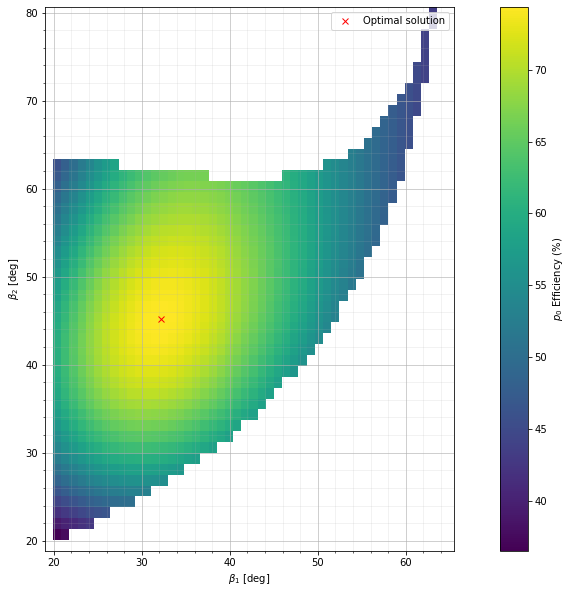

In [16]:
# Plots the efficiency distribution
plt.figure(figsize=(10, 10))
plt.pcolormesh(
    np.rad2deg(b1v), np.rad2deg(b2v), 100 * d, cmap="viridis",
)
cb = plt.colorbar(label="$p_0$ Efficiency (%)")

# Plots optimal solution in red X
plt.plot(*np.rad2deg(betas[:2]), "rx", label="Optimal solution")

# plt.title(r"Total Pressure Efficiency as a function of $\beta_1$ and $\beta_2$")
plt.xlabel(r"$\beta_1$ [deg]")
plt.ylabel(r"$\beta_2$ [deg]")
plt.legend()

# Grid and ticks
plt.axis("scaled")
plt.minorticks_on()
plt.grid(visible=True, axis="both", which="major", linewidth=1, alpha=0.6)
plt.grid(visible=True, axis="both", which="minor", linewidth=0.5, alpha=0.3)

# Color bar
plt.savefig("gradient.pdf", bbox_inches="tight")
plt.show()


### Plot optimal flow properties

In [17]:
# Prepares the data as a matrix
data = np.stack(
    [(*f.static_values(), *f.aux_values(), *f.total_values()) for f in flows]
)
# Saves data to CSV file
np.savetxt("data.csv", data, fmt="%8.5g", delimiter=",")


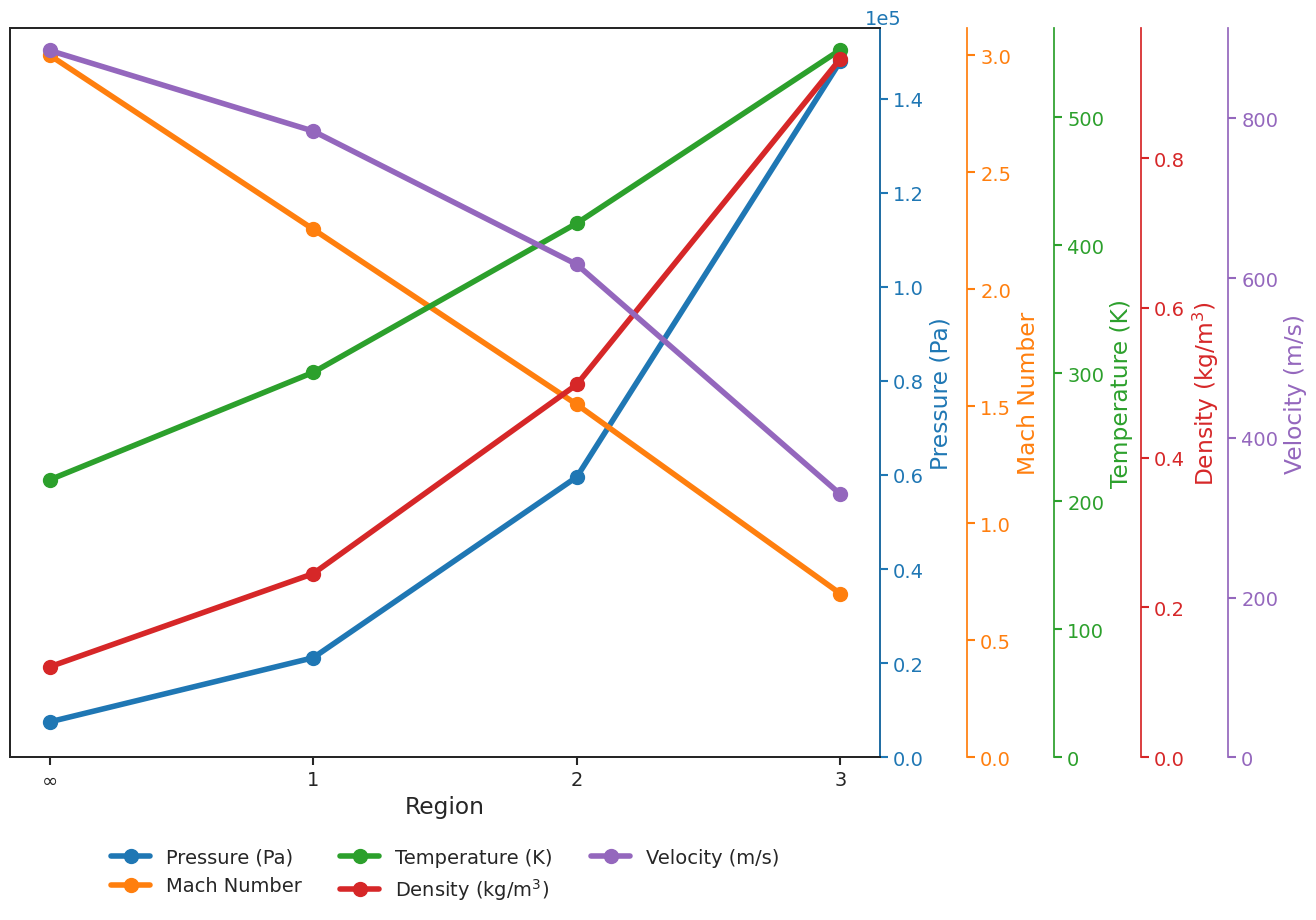

In [18]:
# Plots the flow variation over the diffuser
xt = np.arange(len(data))
with plt.style.context(styles), plt.rc_context(
    rc={"lines.marker": "o", "lines.markersize": 10}
):
    fig, axes = plot_flow_evolution(data, xt, cols=[0, 1, 2, 3, 5])
    # Sets the lower axis
    axes[0].set_xlabel("Region")
    axes[0].set_xticks(xt)
    axes[0].set_xticklabels([r"$\infty$", *np.arange(1, len(data))])
plt.savefig("diffuser_properties.pdf", bbox_inches="tight")
plt.show()


# PART 2

## Initial data

In [19]:
# Sets problem parameters
# The cross-sectional area after the normal shockwave can be arbitrarily small. For this
# geometry, it can also be as large as about 0.3 * D.

# D was chosen to be unitary;
D = 1
D_inlet = 1 * D
D_outlet = 1 * D
# The cross sectional area was arbitrarily chosen to be 0.25 * D
D_entrance = 0.3 * D
# Temperature change
delta_temp = 1500
# Total Values from Part 1
p0, T0, rho0 = flows[-1].total_values()
# Creates new Flow list for Part 2
flows2 = [flows[-1]]
print("Flow after diffuser:", flows2[-1])


Flow after diffuser: Flow(
	Pressure: 1.48e+05
	Mach: 0.6986
	Temperature: 552.7
	Density: 0.9328
	fluid: Fluid(R=287.058, gamma=1.4)
)


## Expansion

In [20]:
# Calculates Mach number using the area-Mach relation
# Calculates virtual throat
D_virtual = D_entrance / area_mach(flows2[-1].mach, flows2[-1].fluid.gamma)
# Solves area-Mach relation for the new Mach number
expanded_mach = root_scalar(
    lambda M: area_mach(M, flows2[-1].fluid.gamma) - D / D_virtual,
    bracket=[1, 1e-2],
    method="brentq",
).root

# Appends new Flow to the list
flows2.append(Flow.from_total_values(p0, expanded_mach, T0, rho0, flows2[-1].fluid))
print("Flow after expansion:", flows2[-1])


Flow after expansion: Flow(
	Pressure: 2.013e+05
	Mach: 0.161
	Temperature: 603.5
	Density: 1.162
	fluid: Fluid(R=287.058, gamma=1.4)
)


In [21]:
print(D_virtual / D)

0.2738683783763921


## Heat addition

To calculate the properties after heat addition, equations (3.78), (3.79), (3.81) from @anderson2021. These equations are written down here as needed before they are implemented.

$$\tag{3.81}
\frac{T_2}{T_1} = \left( \frac{1 + \gamma {M_1}^2}{\gamma {M_2}^2} \right)^2
                  \left( \frac{{M_2}^2}{{M_1}^2} \right)
$$

In [22]:
# Calculates temperature after heat addition
expanded_temp = flows2[-1].temperature
heated_temp = expanded_temp + delta_temp

# Calculates Mach number after heat addition
# Part of Equation (3.81) @anderson2021 that doesn't depend on the new Mach number
const_part = (
    np.sqrt(heated_temp / expanded_temp)
    * expanded_mach
    / (1 + flows2[-1].fluid.gamma * expanded_mach * expanded_mach)
)
# Solves Equation (3.81) @anderson2021 (modified) for the new Mach number
heated_mach = root_scalar(
    lambda M: const_part - M / (1 + flows2[-1].fluid.gamma * M * M),
    bracket=[1, 0],
    method="brentq",
).root
print(f"New Mach number: {heated_mach:.4}")


New Mach number: 0.3358


$$\tag{3.78}
 \frac{p_2}{p_1} = \frac{1 + \gamma {M_1}^2}{1 + \gamma {M_2}^2}
$$

$$\tag{3.79}
 \frac{\rho_2}{\rho_1} = \frac{p_2}{p_1} \frac{T_1}{T_2}
$$

In [23]:
# Calculates remaining Flow properties after heat addition
# Equation (3.78) @anderson2021
heated_pressure = (
    flows2[-1].pressure
    * (1 + flows2[-1].fluid.gamma * expanded_mach * expanded_mach)
    / (1 + flows2[-1].fluid.gamma * heated_mach * heated_mach)
)
# Equation (3.79) @anderson2021
heated_rho = (
    flows2[-1].density
    * heated_pressure
    / flows2[-1].pressure
    * expanded_temp
    / heated_temp
)

# Appends new Flow to the list
flows.append(
    Flow(heated_pressure, heated_mach, heated_temp, heated_rho, flows2[-1].fluid)
)
print("Flow after heat addition:", flows[-1])


Flow after heat addition: Flow(
	Pressure: 1.802e+05
	Mach: 0.3358
	Temperature: 2.103e+03
	Density: 0.2984
	fluid: Fluid(R=287.058, gamma=1.4)
)


## Nozzle

### Geometry

In [24]:
# Calculates throat semi-area
D_throat = D / area_mach(heated_mach, flows[-1].fluid.gamma)
print(f"Throat area: {D_throat}")


Throat area: 0.542665144954579


In [25]:
# Creates the 2 nozzle geometries
bellFunc, crit_len, max_len = bellNozzleGenerator(
    1.2 * D_inlet, D_throat, 1.5 * D_outlet, D_throat, D_inlet, D_outlet
)
coneFunc, _, _ = coneNozzleGenerator(crit_len, max_len, D_throat, D_inlet, D_outlet)

x = np.hstack(
    [np.linspace(0, crit_len, 200, endpoint=False), np.linspace(crit_len, max_len, 200),],
)
bell = np.array([x, bellFunc(x)])
cone = np.array([x, coneFunc(x)])
nozzle_curves = [bell, cone]


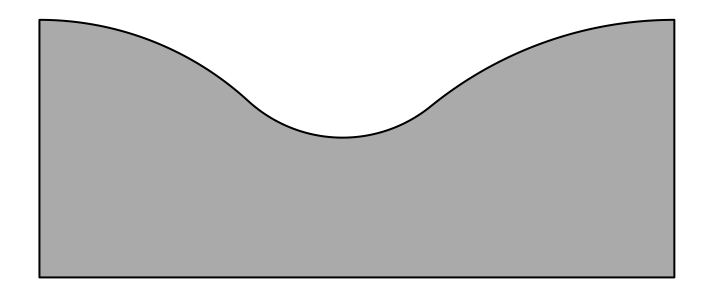

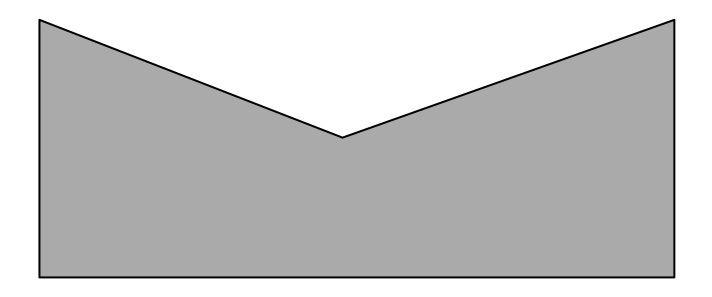

In [26]:
for x, y in nozzle_curves:
    plt.figure(figsize=(10, 10))
    plt.fill_between(x, y, 0, facecolor="#aaa", edgecolor="black", linewidth=2)
    plt.axis("scaled")
    plt.axis("off")
    plt.tight_layout()
plt.show()


### Flow properties

In [27]:
nozzles_flows = np.empty([len(nozzle_curves), len(x)], Flow)
p0_nozzle, T0_nozzle, rho0_nozzle = flows2[-1].total_values()
for n, curve in enumerate(nozzle_curves):
    # Calculates the Mach number across the nozzle.
    crit_index = np.argmin(curve[1])
    D_crit = curve[1, crit_index]
    crit_x = curve[0, crit_index]
    machs = np.array(
        [
            root_scalar(
                lambda M: area_mach(M, flows2[-1].fluid.gamma) - y_ / D_crit,
                # The sign function selects solution branch according to starting flow
                # and position relative to critical length
                bracket=[1, 100 ** np.sign((1 - flows2[-1].mach) * (x_ - crit_x))],
                method="brentq",
            ).root
            for x_, y_ in curve.T
        ]
    )
    nozzles_flows[n, :] = np.array(
        [
            Flow.from_total_values(
                p0_nozzle, mach, T0_nozzle, rho0_nozzle, flows2[-1].fluid
            )
            for mach in machs
        ]
    )


### Contour plots 

In [28]:
def plot_nozzle_prop(prop_name, flow_list, nozzle_curve, ax=None):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    if ax is None:
        ax = plt.gca()
    prop = np.array([flow.__getattribute__(prop_name) for flow in flow_list])
    x, y = nozzle_curve
    plot = plt.contourf([x, x], [np.zeros_like(y), y], [prop, prop], levels=10)
    plt.axis("scaled")
    # cb = plt.colorbar(label=prop_name, orientation="vertical")
    axins = inset_axes(
        plt.gca(),
        width="5%",
        height="100%",
        loc="lower left",
        bbox_to_anchor=(1.02, 0.0, 1, 1),
        bbox_transform=ax.transAxes,
        borderpad=0,
    )
    cb = plt.gcf().colorbar(plot, cax=axins, label=prop_name)
    cb.formatter.set_powerlimits((-3, 3))
    cb.formatter.set_scientific(True)


def plot_nozzles_props(prop_list, nozzle_flow_list, curve_list):
    for property in prop_list:
        for nozzle_flow, curve in zip([*nozzle_flow_list], curve_list):
            plt.figure()
            plot_nozzle_prop(property, nozzle_flow, curve)
    plt.show()


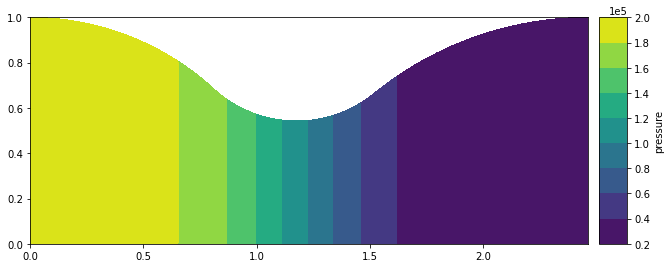

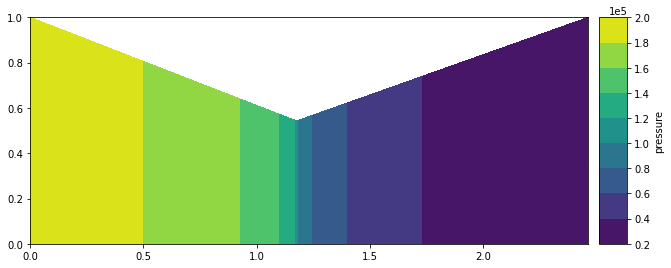

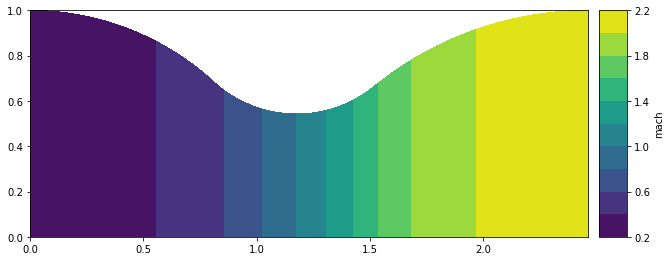

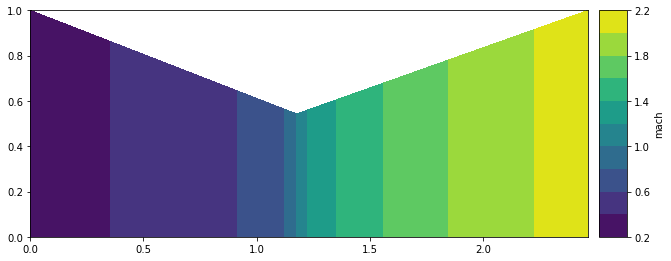

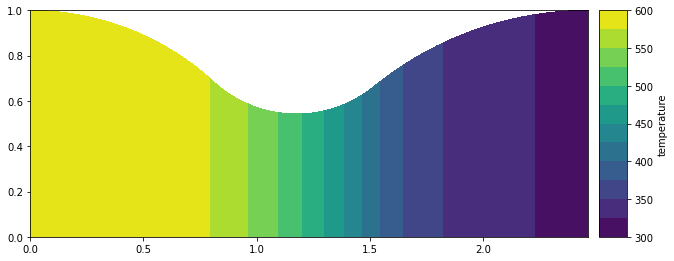

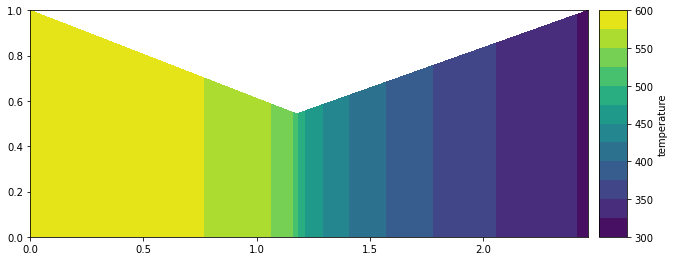

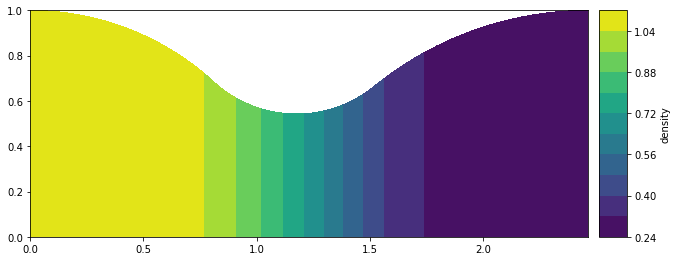

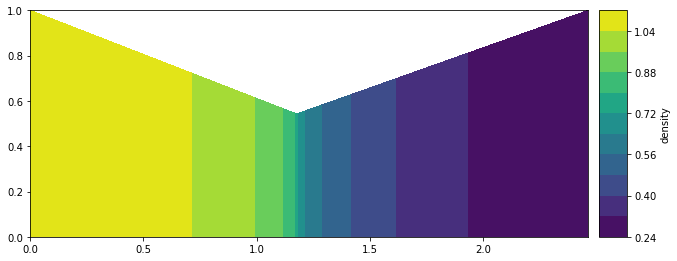

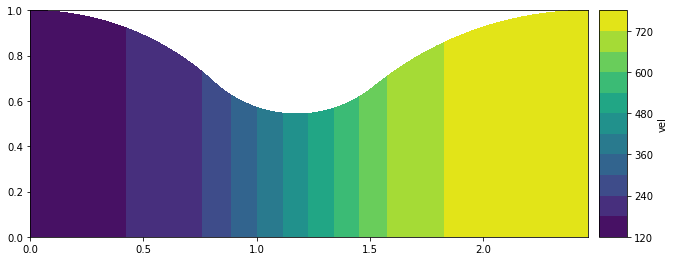

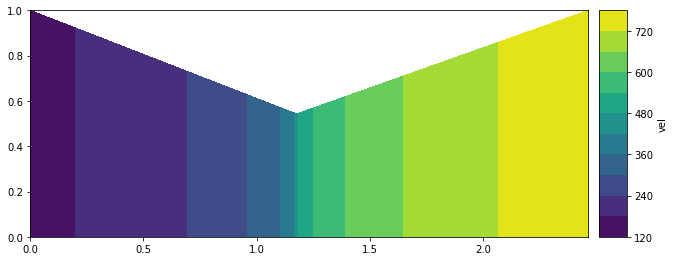

In [29]:
with plt.rc_context({'figure.figsize': (10, 10)}):
    plot_nozzles_props(
        ["pressure", "mach", "temperature", "density", "vel"], nozzles_flows, nozzle_curves
    )


### Line plot

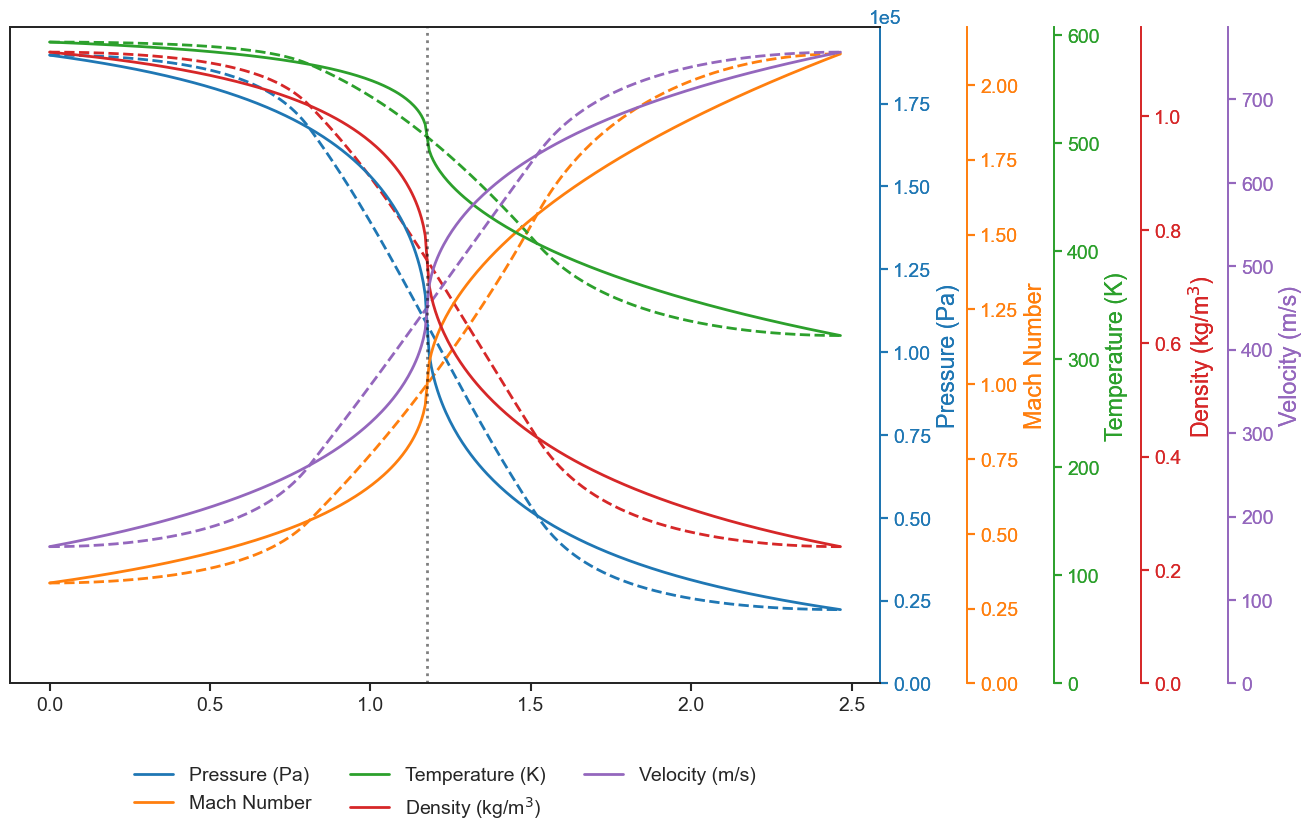

In [30]:
with plt.style.context(styles):
    fig, ax = plt.subplots(figsize=(10, 10))
    for nozzle_flows, line_style in zip(nozzles_flows, ["dashed", "solid", "-."]):
        with plt.rc_context(
            {"lines.linestyle": line_style, "lines.marker": "", "lines.linewidth": 2}
        ):
            data2 = np.stack(
                [
                    (*f.static_values(), *f.aux_values(), *f.total_values())
                    for f in nozzle_flows
                ]
            )
            _, axes = plot_flow_evolution(data2, x, (fig, ax), cols=[0, 1, 2, 3, 5])
    plt.axvline(crit_len, color="black", linestyle="dotted", linewidth=2, alpha=0.5)
    plt.savefig("nozzle_evolution.pdf", bbox_inches="tight")
    plt.show()


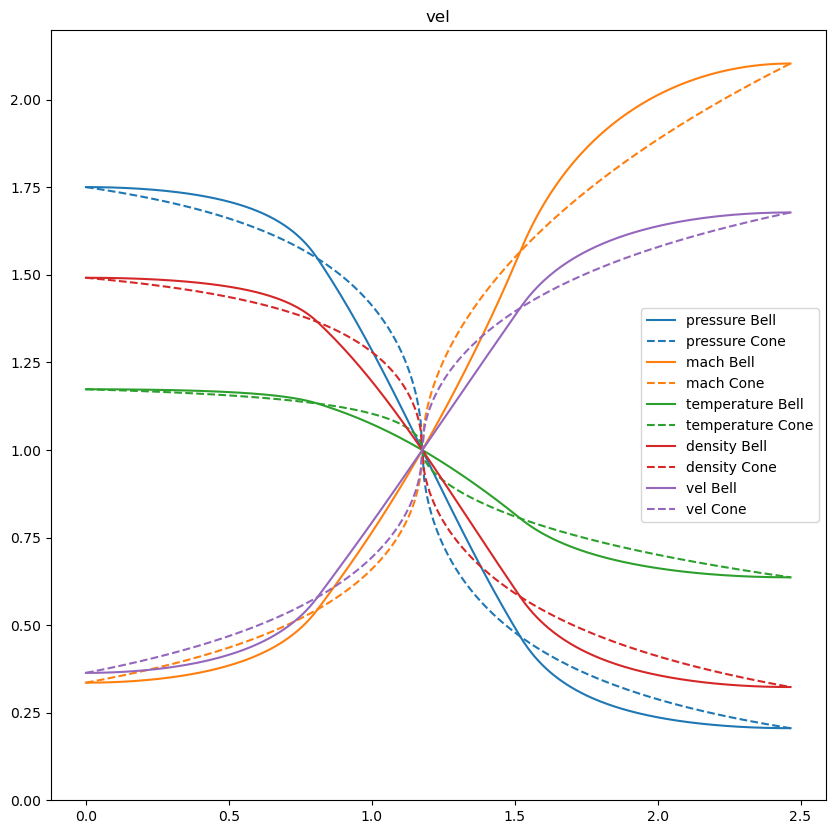

In [31]:
with plt.style.context("default"):
    plt.figure(figsize=(10, 10))
    for prop, color in zip(
        ["pressure", "mach", "temperature", "density", "vel"], colors
    ):
        plt.title(prop)
        for nozzle_flows, nozzle_names, line_style in zip(
            nozzles_flows, ["Bell", "Cone"], ["-", "--"]
        ):
            y = [f.__getattribute__(prop) for f in nozzle_flows]
            y = y / y[crit_index]
            plt.plot(
                x, y, linestyle=line_style, color=color, label=f"{prop} {nozzle_names}",
            )
        plt.ticklabel_format(scilimits=(-3, 3))
        plt.autoscale()
        plt.ylim(bottom=0)
        plt.legend()

